In [11]:
from compute_auc import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter

In [12]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.size"] = 16

In [13]:
def get_reward_curve(tensorboard_log_dir):
    # Initialize an EventAccumulator and load the event file (TensorBoard log file)
    event_acc = EventAccumulator(tensorboard_log_dir)
    event_acc.Reload()

    # Get the reward data
    reward_data = event_acc.Scalars("rollout/ep_rew_mean")

    # Extract the step numbers and corresponding rewards
    _steps = [entry.step for entry in reward_data]
    _rewards = [entry.value for entry in reward_data]
    
    # normalize and numpify the steps and rewards
    steps = np.array(_steps)
    rewards = np.array(_rewards)
    
    return steps, rewards

In [21]:
def get_data(tensorboard_logs_path, prefix="./logs/ppo/", default_length=98):
    # Use the function to find all files with 'events.out.tfevents' in their names
    event_folders = find_folders(prefix, tensorboard_logs_path)
    event_files = []
    for folder in event_folders:
        event_files.extend(
            find_files(prefix + folder + "/", "*events.out.tfevents*")
        )

    print(event_files)
    
    data = []

    for filename in event_files:
        try:
            _steps, _rewards = get_reward_curve(filename)
            data.append(
                {
                    "filename": filename,
                    "steps": _steps,
                    "rewards": _rewards
                }
            )
        except:
            continue

    return data

In [22]:
def process_data(data, default_length=98):
    _data = []
    for d in data:
        if d["rewards"].shape[0] == default_length:
            _data.append(d)

    return _data

In [24]:
base_data = get_data("miniworld_gotoobj_tensorboard", prefix="./logs/ppo/")

[]


In [17]:
name_list = [
    "mission",
    "mission_freeze",
    "actor",
    "actor_freeze",
    "critic",
    "critic_freeze",
    "mission_actor",
    "mission_actor_freeze",
    "mission_critic",
    "mission_critic_freeze",
    "mission_actor_critic",
    "mission_actor_critic_freeze",
]

In [18]:
def plot_subplot(data, axs, i, offset=None):
    formatter = ScalarFormatter(useMathText=True)
    _data = data[:offset]

    if offset is not None:
        _data = data[:offset]
    
    all_rewards = np.concatenate([d["rewards"][np.newaxis, :] for d in _data], axis=0)
    axs[i].fill_between(data[0]["steps"], np.min(all_rewards, axis=0), np.max(all_rewards, axis=0), color="cornflowerblue", alpha=0.1)

    for d in _data:
        axs[i].plot(d["steps"], d["rewards"], alpha=0.1, linewidth=2)
        
    axs[i].plot(_data[0]["steps"], np.mean(all_rewards, axis=0), color="cornflowerblue", linewidth=4)
    
    axs[i].set_xlim([0, 2e5])
    axs[i].set_ylim([0, 1.0])
    axs[i].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    axs[i].xaxis.major.formatter._useMathText = True

    axs[i].xaxis.set_major_locator(MultipleLocator(5e4))
    axs[i].xaxis.set_minor_locator(MultipleLocator(5e4/4))
    axs[i].yaxis.set_major_locator(MultipleLocator(0.25))
    axs[i].yaxis.set_minor_locator(MultipleLocator(0.25/4))

    axs[i].grid(True, "minor", color="0.85", linewidth=0.50, zorder=-20)
    axs[i].grid(True, "major", color="0.65", linewidth=0.75, zorder=-10)
    axs[i].tick_params(which="both", bottom=False, left=False)

In [20]:
base_data

[]

ValueError: need at least one array to concatenate

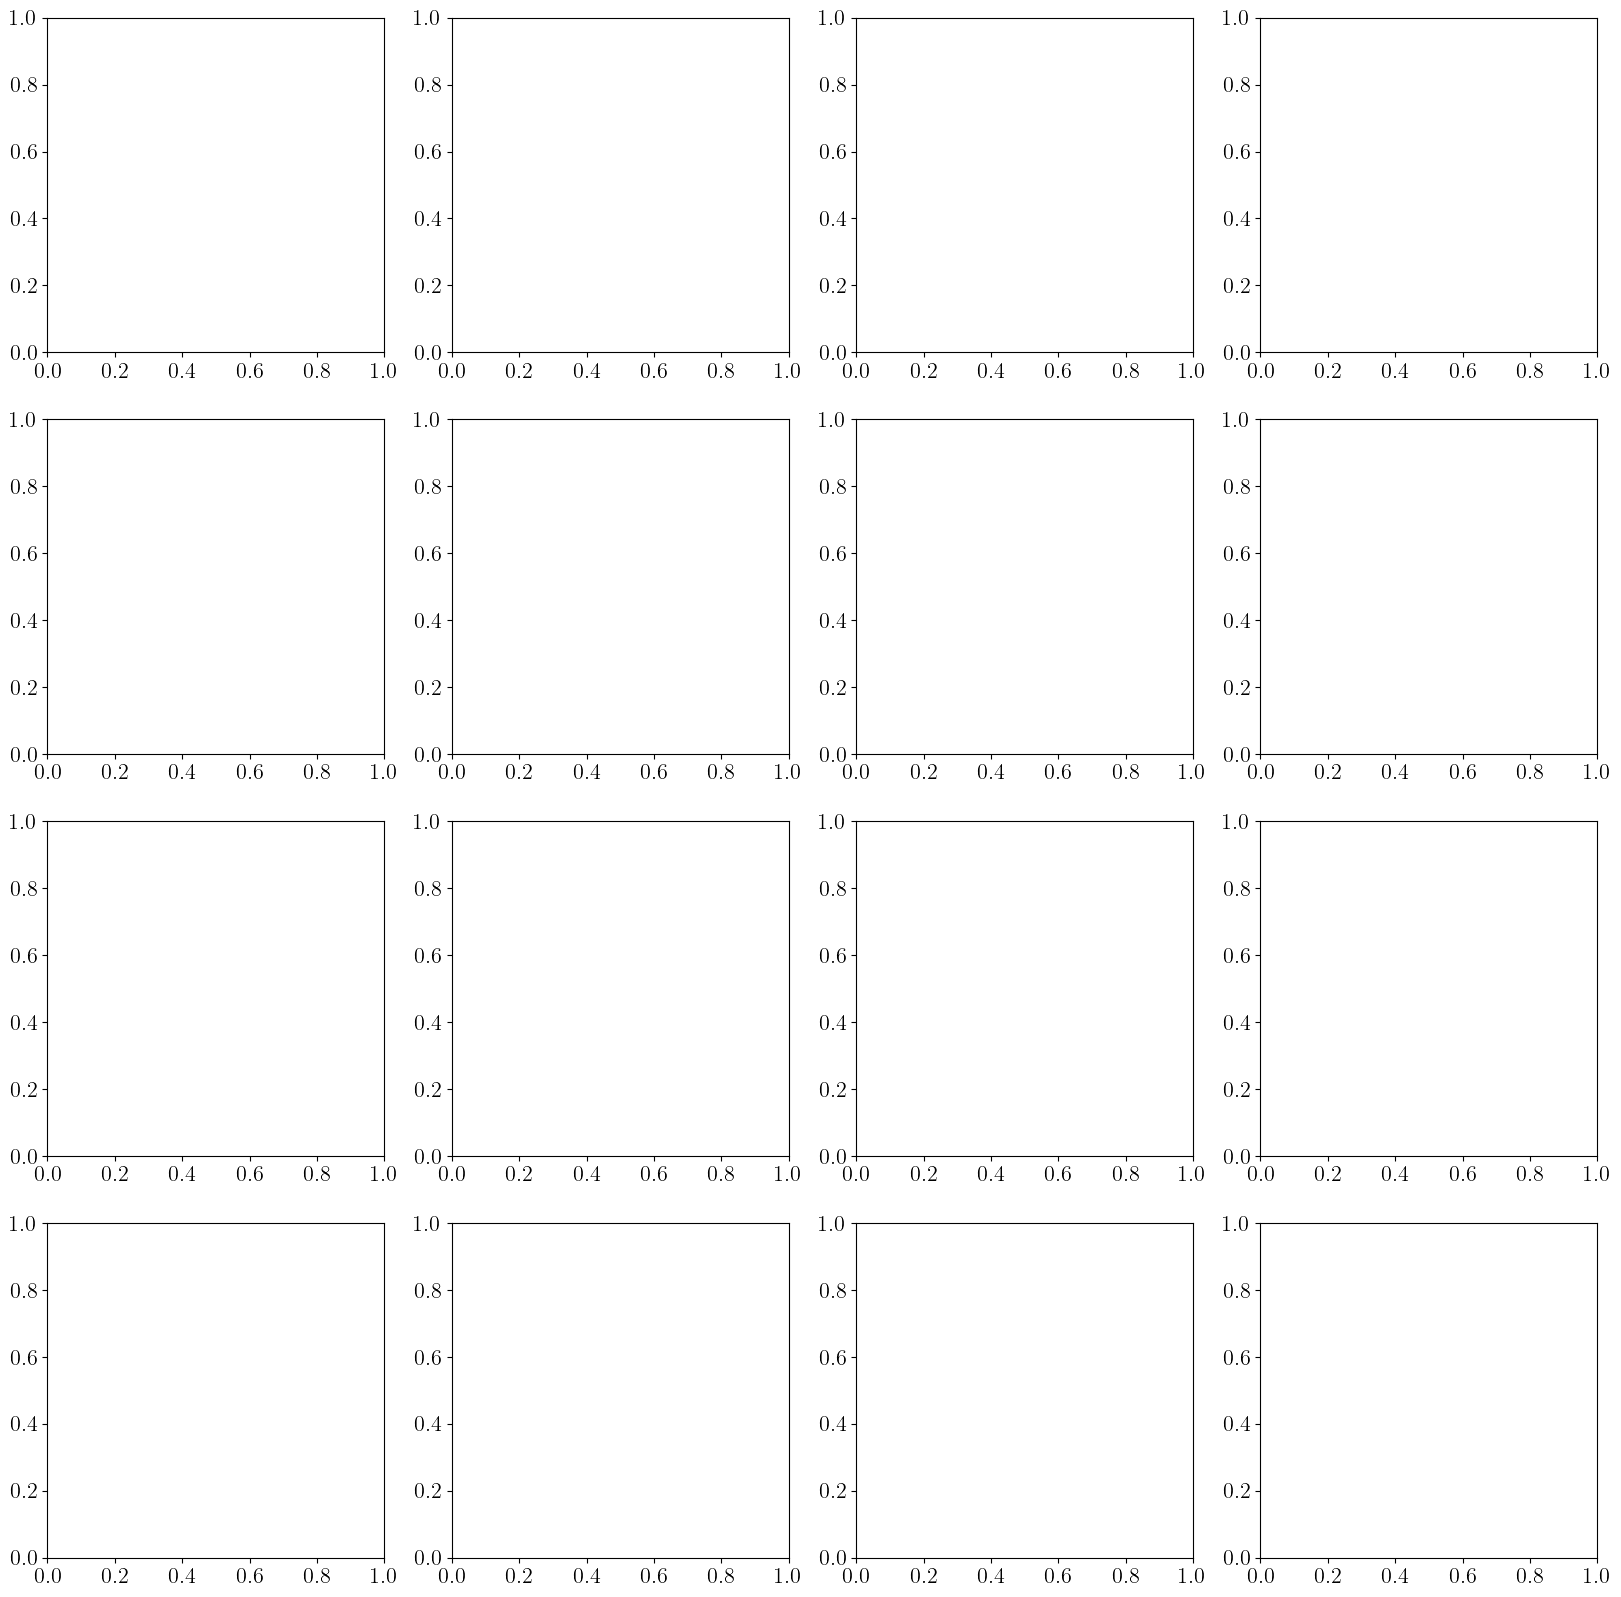

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.reshape(-1)

plot_subplot(base_data, axs, 0, offset=-1)

for i, name in enumerate(name_list):
    try:
        _data = get_data(f"miniworld_gotoobj_{name}_transfer_*_tensorboard", prefix="./logs/ppo/")
        _data = process_data(_data, default_length=98)
        plot_subplot(_data, axs, i+1)
    except:
        continue
    
    axs[i+1].set_title(name)
    axs[i+1].set_xlabel("Timesteps")

axs[0].set_title("Baseline")
axs[-1].axis("off")
axs[-2].axis("off")
axs[-3].axis("off")

for i in [0, 4, 8, 12]:
    axs[i].set_ylabel("Rewards")

plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.savefig("imgs/learning_curves.png", dpi=200, transparent=False, bbox_inches="tight")
plt.show()